In [1]:
import pandas as pd


In [2]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'P_or_S']

def sort(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on median of observed travel time.

    If there are multiple source and station block combinations, we keep the
    row corresponding to the median observed travel time (observed_tt).

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: None
    """

#     log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

#     log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(by=['source_block',
                                   'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block',
                                     'event_number', SOURCE_LONGITUDE,
                                     SOURCE_LATITUDE, 'source_depth'],
                             keep='first',
                             inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df


In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:
inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'
residual_cutoff=10.0
sortedfile='sortedfile.csv'

In [5]:
finalpdf = sort(inputcsv,sortedfile,residual_cutoff)

In [6]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
509950,1126,8087,-0.6,2281047,45.1696,86.5531,2259.2,166.271,68.0388,573.506289,23.915422,BILL,2
509947,1126,9047,-4.1,2281047,45.1696,86.5531,2259.2,45.734,64.8783,530.264143,21.674992,LSH,2
509948,1126,9399,-3.7,2281047,45.1696,86.5531,2259.2,38.035,64.1633,544.869565,22.420298,TMCR,2
509951,1126,12300,4.3,2281047,45.1696,86.5531,2259.2,58.562,56.4295,678.264426,30.226654,ARU,2
174303,1482,10127,1.0,1219016,40.7319,86.4428,2341.5,45.627,61.6352,589.379694,24.822278,PRGR,2


In [7]:
#sort again
pdf2=sort(sortedfile, 'sortedfile2.csv',10.0)

In [8]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,P_or_S
0,1126,8087,-0.6,2281047,45.1696,86.5531,2259.2,166.271,68.0388,573.506289,23.915422,BILL,2
1,1126,9047,-4.1,2281047,45.1696,86.5531,2259.2,45.734,64.8783,530.264143,21.674992,LSH,2
2,1126,9399,-3.7,2281047,45.1696,86.5531,2259.2,38.035,64.1633,544.869565,22.420298,TMCR,2
3,1126,12300,4.3,2281047,45.1696,86.5531,2259.2,58.562,56.4295,678.264426,30.226654,ARU,2
4,1482,10127,1.0,1219016,40.7319,86.4428,2341.5,45.627,61.6352,589.379694,24.822278,PRGR,2


In [9]:
pdf2.shape

(290313, 13)

In [13]:
import matplotlib.pyplot as plt


<Figure size 432x288 with 0 Axes>

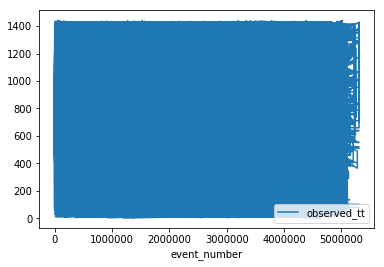

In [22]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

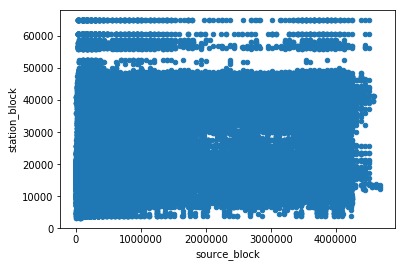

In [23]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

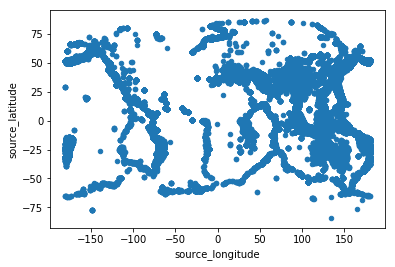

In [25]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

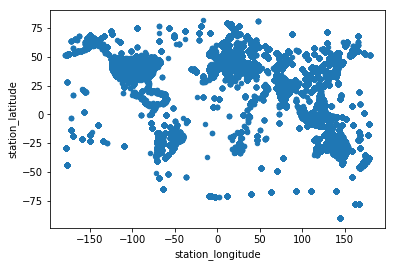

In [26]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')